# **Pretrained alexnet model 사용**

In [1]:
import torch
torch.cuda.is_available()

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [ ]:
! git clone https://github.com/hansam95/LG-Elec-Day9.git

#### **<모듈 임포트>**

In [2]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

#### **<GPU 확인, 사용할 device 설정>**

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### **<Seed/Random state 고정, 재현성을 위해>**

In [4]:
random.seed(777)
np.random.seed(777)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

#### **<데이터 불러오기>**
#### 개미와 벌 분류하기
#### train data class당 대략 120개
#### validatation data class당 대략 70~80개

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(256), # size
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms={'train':train_transform, 'val':val_transform}

<img src='img/img1.png' width='800'></img>

In [6]:
data_dir = "/content/LG-Elec-Day9/data/ant_bee"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = train_dataset.classes

#### **<데이터 시각화>**

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # channel, height, width -> height, width, channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # Given an interval, values outside the interval are clipped to the interval edges.
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

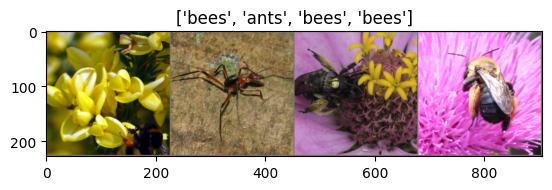

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train'])) # batch, ch, h,w
# Make a grid from batch
out = torchvision.utils.make_grid(inputs) # ch,h,width*batch
imshow(out, title=[class_names[x] for x in classes])

### **<pretrained 모델 불러오기>**

<img src='img/img2.png' width='800'></img>

In [9]:
alexnet = models.alexnet(pretrained=True)
alexnet

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### **<fine-tuning : 마지막 Linear layer>**

In [10]:
for param in alexnet.parameters():
    param.requires_grad = False

In [12]:
#Parameters of newly constructed modules have requires_grad=True by default
num_in = alexnet.classifier[-1].in_features
alexnet.classifier[-1] = nn.Linear(num_in,2)

In [13]:
for param in alexnet.features[0].parameters():
    print(param.requires_grad)

False
False


In [14]:
for param in alexnet.classifier[-1].parameters():
    print(param.requires_grad)

True
True


In [15]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<img src='img/img3.png' width='800'></img>

In [16]:
alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.classifier[-1].parameters(), 
                      lr=0.001, 
                      momentum=0.9)
num_epochs = 10

In [17]:
# best_model_wts = copy.deepcopy(alexnet.state_dict())
best_acc = 0.0

# epoch
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            alexnet.train()  # Set model to training mode
        else:
            alexnet.eval()   # Set model to evaluate mode
    
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = alexnet(inputs)
                _, preds = torch.max(outputs, 1) #outputs값 중에서 큰 class값을 가져옴
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward() # backpropagation
                    optimizer.step() # model weight update
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase] #float은 7자리, double은 15~16자리까지 표현가능
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
        # save model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            content = {
                'epoch': epoch,
                'acc': epoch_acc,
                'model': alexnet.state_dict()
            }
            torch.save(content, 'alex_best.pt')

print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/10
----------
train Loss: 0.6841 Acc: 0.8484
val Loss: 0.6614 Acc: 0.8954
Epoch 2/10
----------
train Loss: 0.2720 Acc: 0.9467
val Loss: 0.7233 Acc: 0.9020
Epoch 3/10
----------
train Loss: 0.1539 Acc: 0.9713
val Loss: 0.6085 Acc: 0.9150
Epoch 4/10
----------
train Loss: 0.2551 Acc: 0.9590
val Loss: 0.7988 Acc: 0.9085
Epoch 5/10
----------
train Loss: 0.0386 Acc: 0.9877
val Loss: 0.7664 Acc: 0.8889
Epoch 6/10
----------
train Loss: 0.0588 Acc: 0.9836
val Loss: 0.7480 Acc: 0.8889
Epoch 7/10
----------
train Loss: 0.1127 Acc: 0.9631
val Loss: 0.8288 Acc: 0.8627
Epoch 8/10
----------
train Loss: 0.0334 Acc: 0.9877
val Loss: 0.7279 Acc: 0.9020
Epoch 9/10
----------
train Loss: 0.1109 Acc: 0.9713
val Loss: 0.8991 Acc: 0.8758
Epoch 10/10
----------
train Loss: 0.0745 Acc: 0.9836
val Loss: 0.7988 Acc: 0.9020
Best val Acc: 0.915033


In [21]:
ckpt = torch.load('alex_best.pt')
alexnet.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [22]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//2, 2, images_so_far)
                plt.axis('off')
                plt.title('real: {} | predicted: {}'.format(class_names[labels[j]],
                                                            class_names[preds[j]]))
                img = inputs.cpu().data[j].permute(1,2,0)*std+mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    return

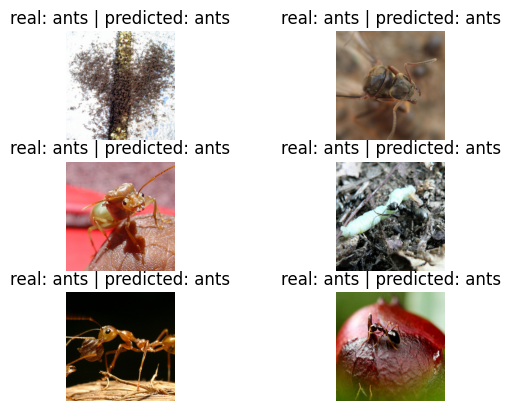

In [23]:
visualize_model(alexnet, num_images=6)

<img src='img/img4.png' width='800'></img>

In [24]:
vgg16 = models.vgg16(pretrained=True)
vgg16

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
for param in vgg16.parameters():
    param.requires_grad = False

#Parameters of newly constructed modules have requires_grad=True by default
num_in = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_in,2)

In [26]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier[-1].parameters(), 
                      lr=0.001, 
                      momentum=0.9)
num_epochs = 10

In [29]:
# best_model_wts = copy.deepcopy(alexnet.state_dict())
best_acc = 0.0

# epoch
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            # cus_lr_scheduler.step()
            vgg16.train()  # Set model to training mode
        else:
            vgg16.eval()   # Set model to evaluate mode
    
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                _, preds = torch.max(outputs, 1) #outputs값 중에서 큰 class값을 가져옴
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward() # backpropagation
                    optimizer.step() # model weight update
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase] #float은 7자리, double은 15~16자리까지 표현가능
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            content = {
                'epoch': epoch,
                'acc': epoch_acc,
                'model': vgg16.state_dict()
            }
            torch.save(content, 'vgg_best.pt')
            # best_model_wts = copy.deepcopy(alexnet.state_dict())

    print()

print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
# alexnet.load_state_dict(best_model_wts)

Epoch 1/10
----------
train Loss: 0.1697 Acc: 0.9262
val Loss: 0.0923 Acc: 0.9739

Epoch 2/10
----------
train Loss: 0.0749 Acc: 0.9795
val Loss: 0.0761 Acc: 0.9739

Epoch 3/10
----------
train Loss: 0.0687 Acc: 0.9713
val Loss: 0.1136 Acc: 0.9673

Epoch 4/10
----------
train Loss: 0.1364 Acc: 0.9508
val Loss: 0.0579 Acc: 0.9804

Epoch 5/10
----------
train Loss: 0.0567 Acc: 0.9795
val Loss: 0.0744 Acc: 0.9608

Epoch 6/10
----------
train Loss: 0.0278 Acc: 0.9877
val Loss: 0.0537 Acc: 0.9739

Epoch 7/10
----------
train Loss: 0.0236 Acc: 0.9959
val Loss: 0.0614 Acc: 0.9673

Epoch 8/10
----------
train Loss: 0.0290 Acc: 0.9918
val Loss: 0.0731 Acc: 0.9608

Epoch 9/10
----------
train Loss: 0.0162 Acc: 0.9959
val Loss: 0.0805 Acc: 0.9673

Epoch 10/10
----------
train Loss: 0.0059 Acc: 1.0000
val Loss: 0.0788 Acc: 0.9673

Best val Acc: 0.980392


In [30]:
ckpt = torch.load('vgg_best.pt')
vgg16.load_state_dict(ckpt['model'])

<All keys matched successfully>

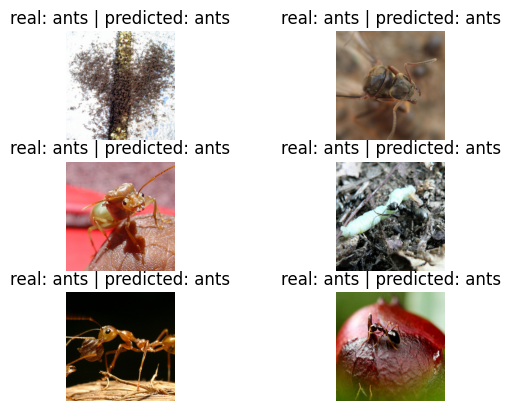

In [31]:
visualize_model(vgg16)

## 전체 모델 학습

In [34]:
alexnet = models.alexnet(pretrained=True)

num_in = alexnet.classifier[-1].in_features
alexnet.classifier[-1] = nn.Linear(num_in,2)

alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
num_epochs = 10

In [35]:
# best_model_wts = copy.deepcopy(alexnet.state_dict())
best_acc = 0.0

# epoch
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            # cus_lr_scheduler.step()
            vgg16.train()  # Set model to training mode
        else:
            vgg16.eval()   # Set model to evaluate mode
    
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = alexnet(inputs)
                _, preds = torch.max(outputs, 1) #outputs값 중에서 큰 class값을 가져옴
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward() # backpropagation
                    optimizer.step() # model weight update
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase] #float은 7자리, double은 15~16자리까지 표현가능
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            content = {
                'epoch': epoch,
                'acc': epoch_acc,
                'model': alexnet.state_dict()
            }
            torch.save(content, 'alex_full_best.pt')
            # best_model_wts = copy.deepcopy(alexnet.state_dict())

    print()

print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
# alexnet.load_state_dict(best_model_wts)

Epoch 1/10
----------
train Loss: 0.7365 Acc: 0.6393
val Loss: 0.6923 Acc: 0.5033

Epoch 2/10
----------
train Loss: 0.5952 Acc: 0.6516
val Loss: 1.6181 Acc: 0.4510

Epoch 3/10
----------
train Loss: 0.5495 Acc: 0.7008
val Loss: 0.6864 Acc: 0.7647

Epoch 4/10
----------
train Loss: 0.5436 Acc: 0.7705
val Loss: 0.5604 Acc: 0.7451

Epoch 5/10
----------
train Loss: 0.2948 Acc: 0.8811
val Loss: 0.4274 Acc: 0.8235

Epoch 6/10
----------
train Loss: 0.3125 Acc: 0.8934
val Loss: 0.6294 Acc: 0.6667

Epoch 7/10
----------
train Loss: 0.5357 Acc: 0.7705
val Loss: 0.5025 Acc: 0.7516

Epoch 8/10
----------
train Loss: 0.2178 Acc: 0.9139
val Loss: 0.3904 Acc: 0.8235

Epoch 9/10
----------
train Loss: 0.2121 Acc: 0.9262
val Loss: 0.3491 Acc: 0.8693

Epoch 10/10
----------
train Loss: 0.1705 Acc: 0.9467
val Loss: 0.4324 Acc: 0.8497

Best val Acc: 0.869281
